# Importing the necessary libraries + useful functions

The initial step involves importing the required libraries and defining helpful functions to enhance the readability of the code that follows.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

In [2]:
def PlotDecomposition(result):
    plt.figure(figsize=(22,18))
    plt.subplot(4,1,1)
    plt.plot(result.observed,label='Observed',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4,1,2)
    plt.plot(result.trend,label='Trend',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals',lw=1)
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def CalculateError(pred,sales):
    percentual_errors = []
    for A_i, B_i in zip(sales, pred):
        percentual_error = abs((A_i - B_i) / B_i)
        percentual_errors.append(percentual_error)
    return sum(percentual_errors) / len(percentual_errors)

In [4]:
def PlotPredictions(plots,title):
    plt.figure(figsize=(18, 8))
    for plot in plots:
        plt.plot(plot[0], plot[1], label=plot[2], linestyle=plot[3], color=plot[4],lw=1)
    plt.xlabel('Date')
    plt.ylabel("Trips")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.show()

In [5]:
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Reading the Uber Trips Dataset and preparing the data

One crucial aspect of this step is resampling the data on an hourly basis, which is particularly important. Initially, the data is not structured for time series prediction. However, once the preparation is complete, we can proceed to train the models.

In [7]:
files = []
# Get all uber rides raw data
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename)) if "raw" in filename else None
# Keep the jun - sep 2014 data on a separate list
files = files[:-1]

In [8]:
# Read and concatenate all CSV files
dataframes = [pd.read_csv(file) for file in files]
uber2014 = pd.concat(dataframes, ignore_index=True)

In [10]:
# Now make sure the date column is set to datetime, sorted and with an adequate name
uber2014['Date/Time'] = pd.to_datetime(uber2014['Date/Time'], format='%m/%d/%Y %H:%M:%S')
uber2014 = uber2014.sort_values(by='Date/Time')
uber2014 = uber2014.rename(columns={'Date/Time':'Date'})
uber2014.set_index('Date',inplace=True)

In [11]:
# Group by hour and count occurrences of 'Base'
hourly_counts = uber2014['Base'].resample('h').count()
# Convert the series to a dataframe
uber2014 = hourly_counts.reset_index()
# Rename columns for clarity
uber2014.columns = ['Date', 'Count']
uber2014.set_index('Date',inplace=True)

In [12]:
uber2014.head()

,Count
Date,
2014-04-01 00:00:00,138
2014-04-01 01:00:00,66
2014-04-01 02:00:00,53
2014-04-01 03:00:00,93
2014-04-01 04:00:00,166


# Choosing Test/Train Split

To select appropriate train/test sets, we first need to visualize the time series and perform a seasonal decomposition. This helps us analyze the trend and determine a suitable approach for splitting the data.

In [13]:
print(uber2014.index.min())
print(uber2014.index.max())

2014-04-01 00:00:00
2014-09-30 22:00:00


In [14]:
# Let's plot the series
plt.figure(figsize=(20, 8))
plt.plot(uber2014['Count'],linewidth = 1, color='darkslateblue')
plt.xticks(rotation=30,ha='right')
plt.show()

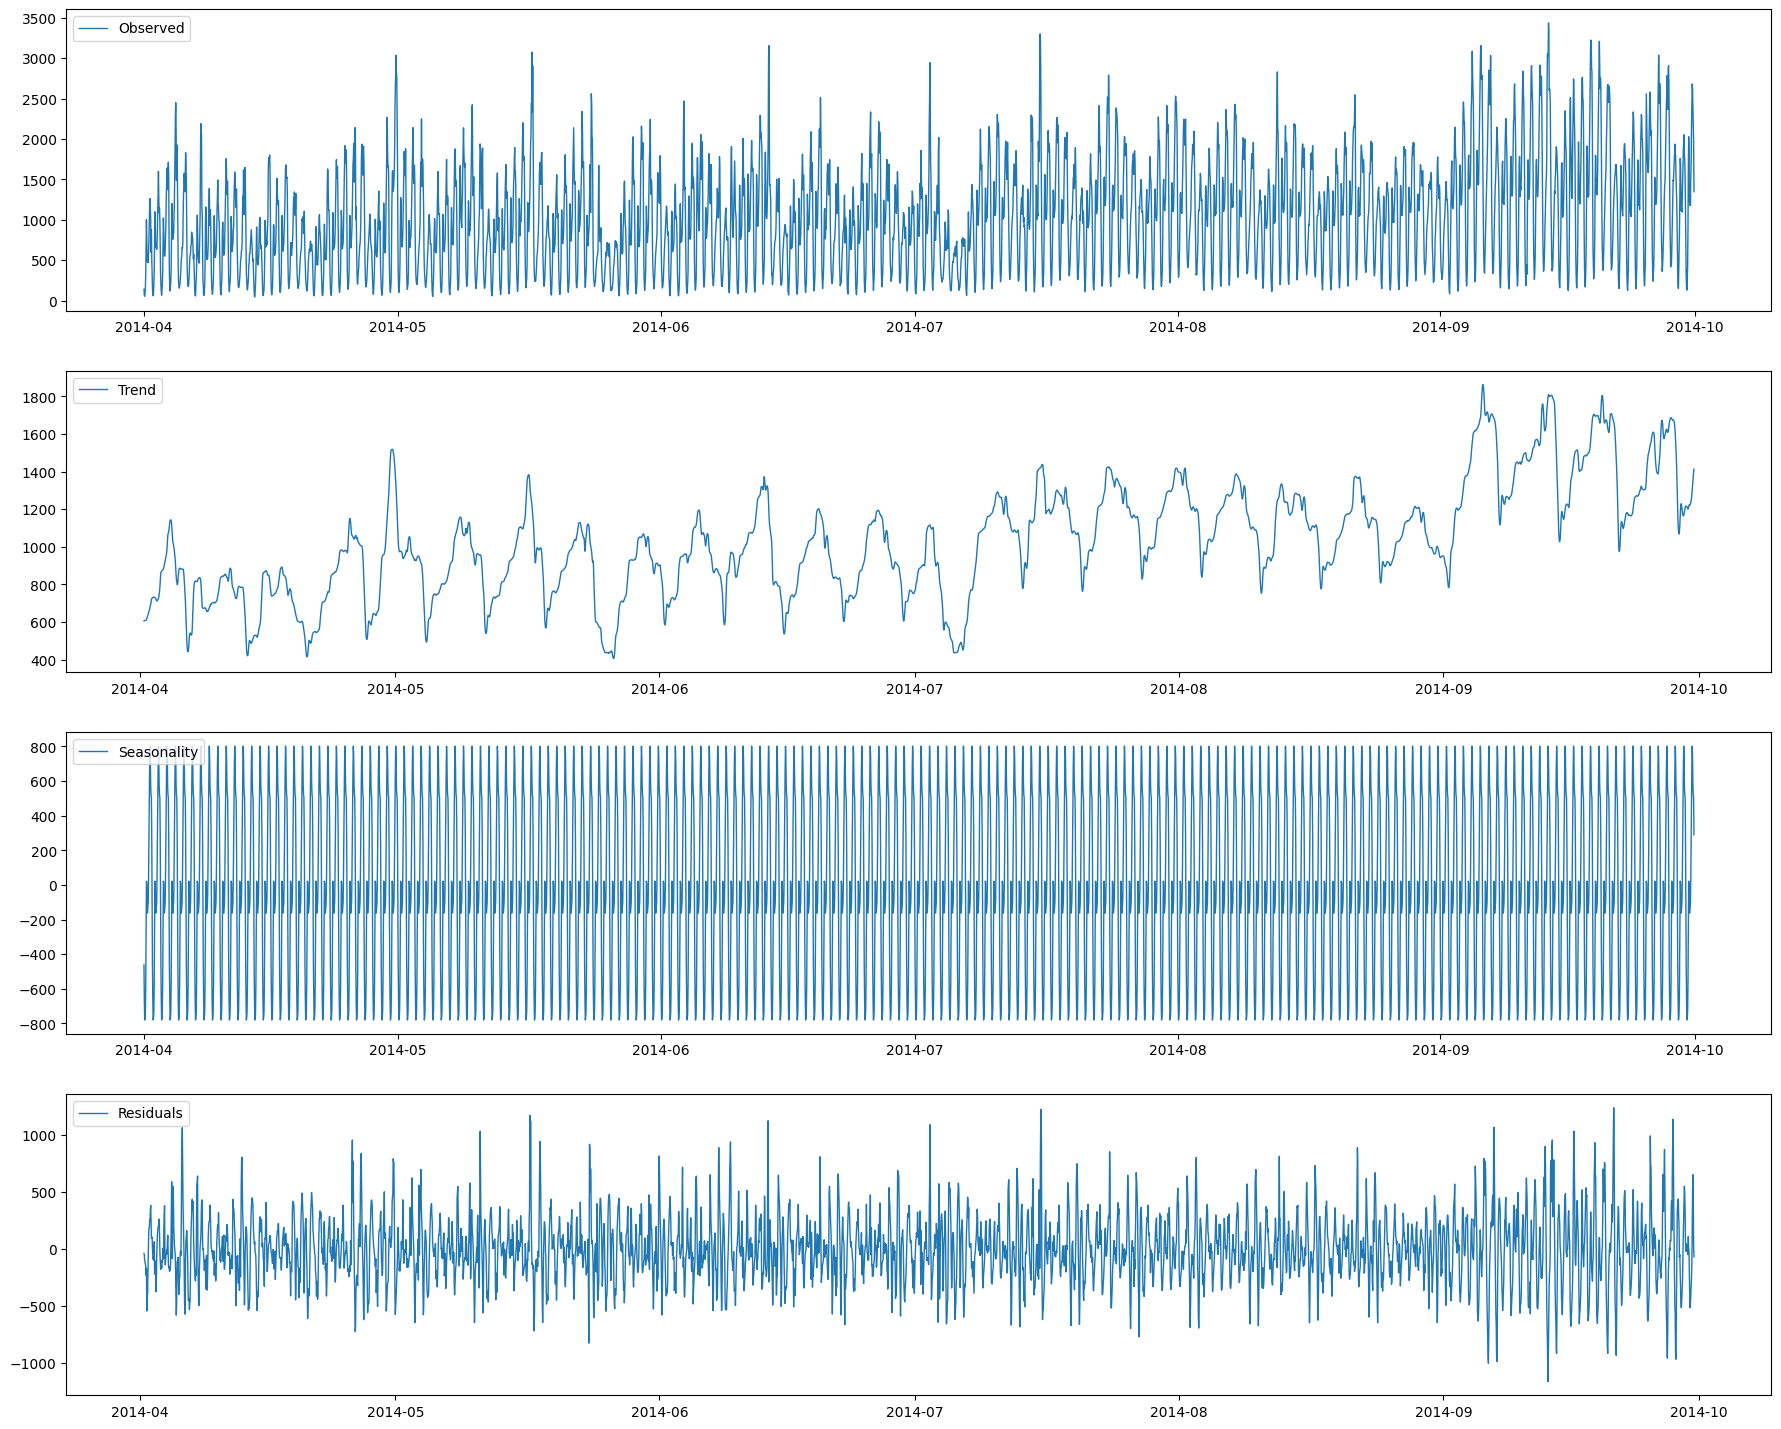

In [15]:
result=seasonal_decompose(uber2014['Count'],model='add', period=24*1)
PlotDecomposition(result)

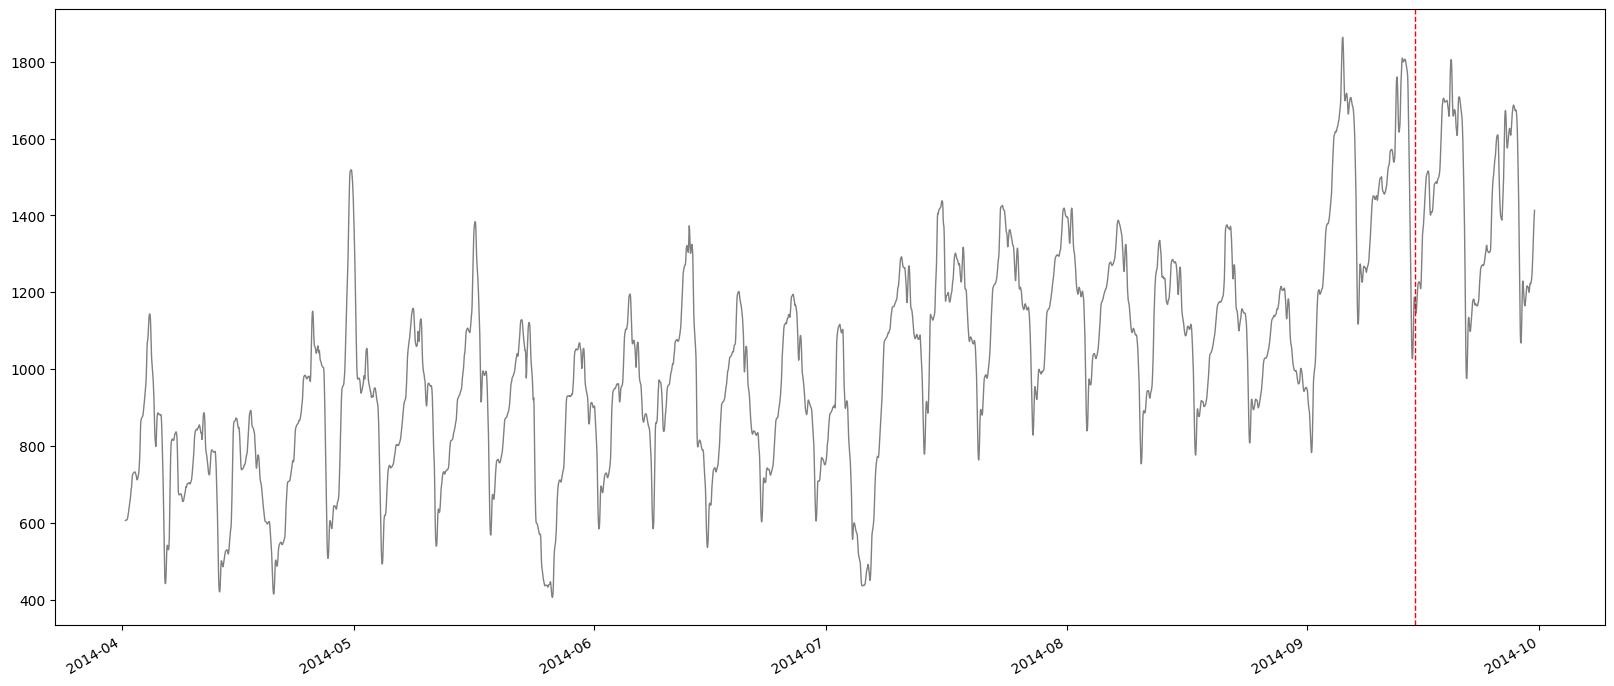

In [16]:
cutoff_date = '2014-09-15 00:00:00'
plt.figure(figsize=(20, 8))
plt.plot(result.trend,linewidth = 1, color='gray')
plt.axvline(x=pd.Timestamp(cutoff_date), color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=30,ha='right')
plt.show()

As observed, the trend remains relatively stable until around September 2014, after which it rises to include four additional peaks. Using the first two peaks as training data and the remaining two as test data would be a more effective approach. This is particularly crucial because a standard 80/20 split could lead to errors due to the noticeable trend increase.

In [17]:
uber2014_train = uber2014.loc[:cutoff_date]
uber2014_test = uber2014.loc[cutoff_date:]

<Axes: title={'center': 'Train / Test Sets'}, xlabel='Date'>

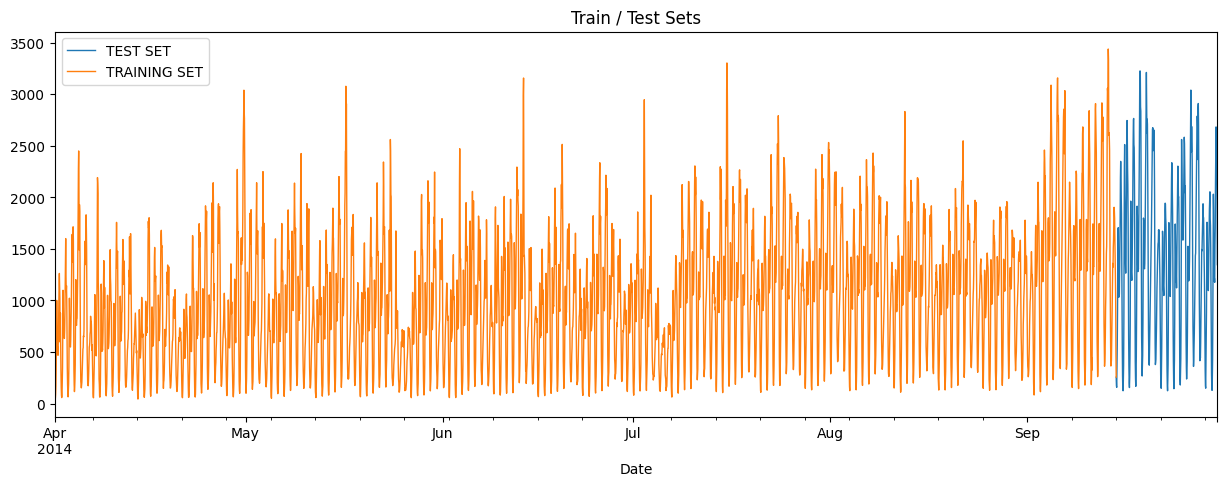

In [18]:
uber2014_test.rename(columns={'Count':'TEST SET'}).join(uber2014_train.rename(columns={'Count':'TRAINING SET'}), how='outer').plot(figsize=(15,5),title='Train / Test Sets', style='-',lw=1)

In [21]:
# Set the window size
window_size = 24
# Split data into training and test sets
X_train, y_train = create_lagged_features(uber2014_train['Count'].values,window_size)

In [22]:
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:], uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

In [23]:
seed = 12345

# XGBoost Model model

XGBoost is among the most powerful machine learning algorithms available, but it is often susceptible to overfitting. To mitigate this, we employ cross-validation and carefully fine-tune the training process.

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

In [25]:
xgb_param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [3, 6, 9],
'learning_rate': [0.01, 0.1, 0.3],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0]
}

In [26]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)

In [29]:
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1,verbose=1) 
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=12345, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [30]:
print("Best XGBoost parameters:", xgb_grid_search.best_params_)

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}


In [31]:
xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

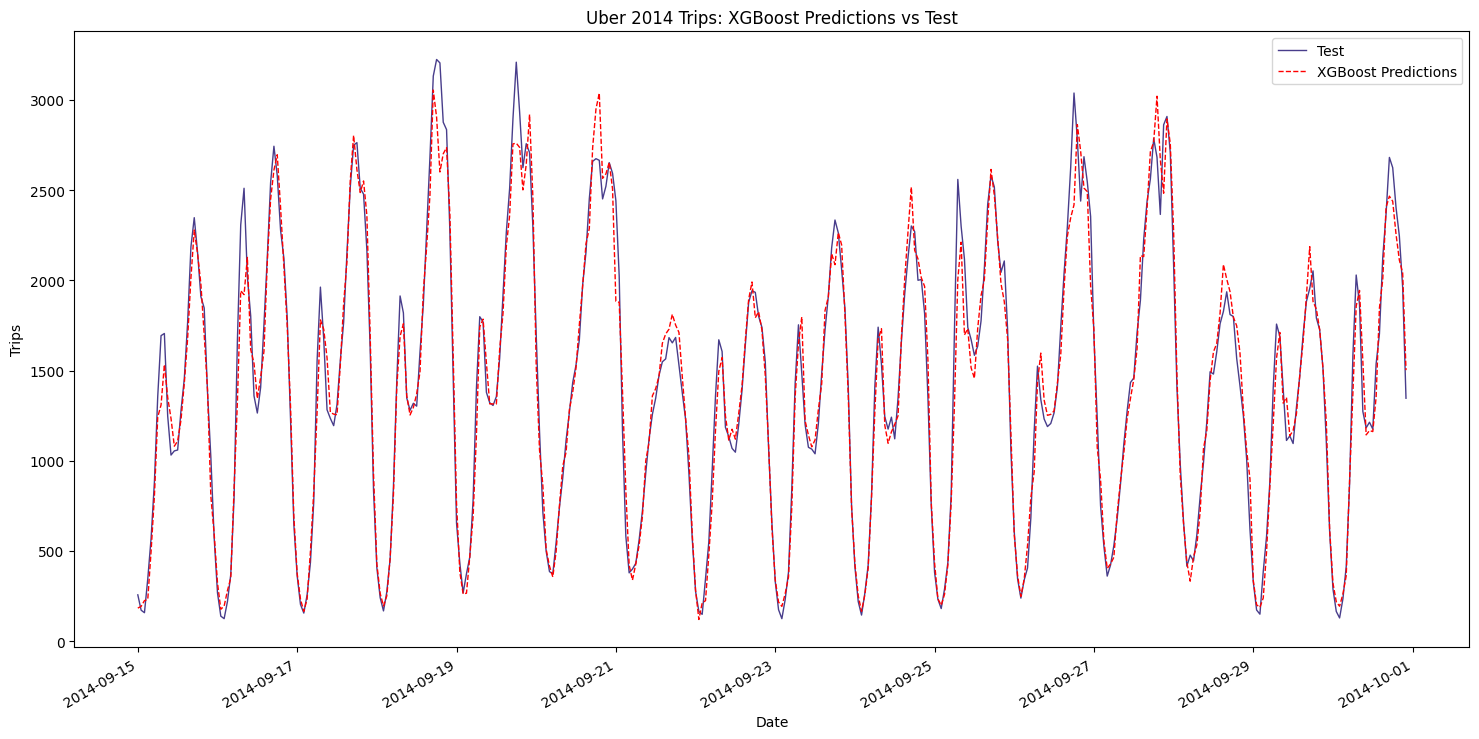

In [32]:
PlotPredictions([
(uber2014_test.index,uber2014_test['Count'],'Test','-','darkslateblue'),
(uber2014_test.index,xgb_predictions,'XGBoost Predictions','--','red')],
'Uber 2014 Trips: XGBoost Predictions vs Test')

In [33]:
xgb_mape = mean_absolute_percentage_error(uber2014_test['Count'], xgb_predictions)
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')

XGBoost MAPE:		8.37%


# Random Forest model

Finally, Random Forests are generally less prone to overfitting. However, based on experience, they typically do not outperform XGBoost in terms of predictive performance.

In [34]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [35]:
rf_model = RandomForestRegressor(random_state=seed)

In [36]:
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [37]:
print("Best Random Forest parameters:", rf_grid_search.best_params_)

Best Random Forest parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [38]:
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)

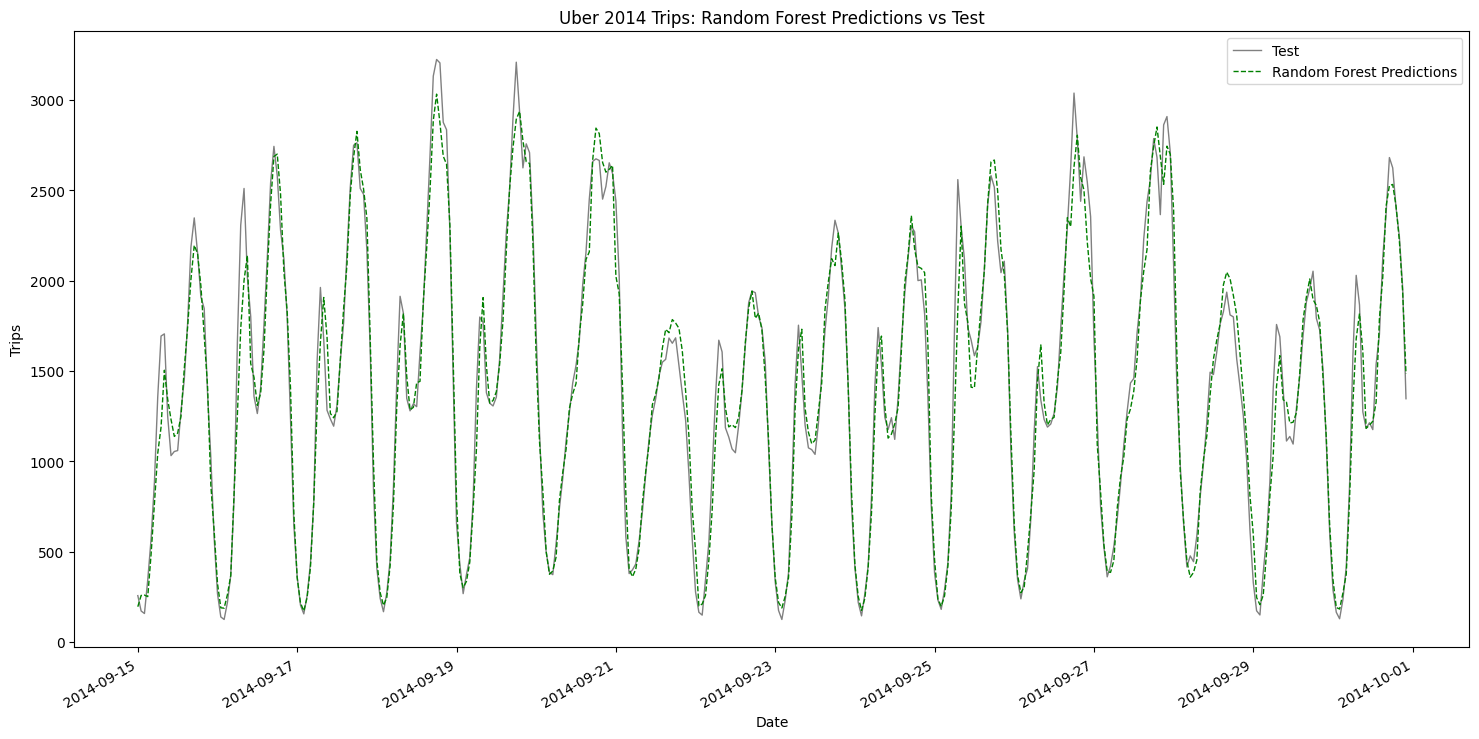

In [39]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],'Uber 2014 Trips: Random Forest Predictions vs Test')

In [40]:
rf_mape = mean_absolute_percentage_error(uber2014_test['Count'], rf_predictions)
print(f'Random Forest Mean Percentage Error:\t{rf_mape:.2%}')

Random Forest Mean Percentage Error:	9.61%


# Gradient Boosted Regression Tree model

In [41]:
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [42]:
gbr_model = GradientBoostingRegressor(random_state=seed)

In [43]:
gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [44]:
print("Best Random Forest parameters:", gbr_grid_search.best_params_)

Best Random Forest parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [45]:
gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)

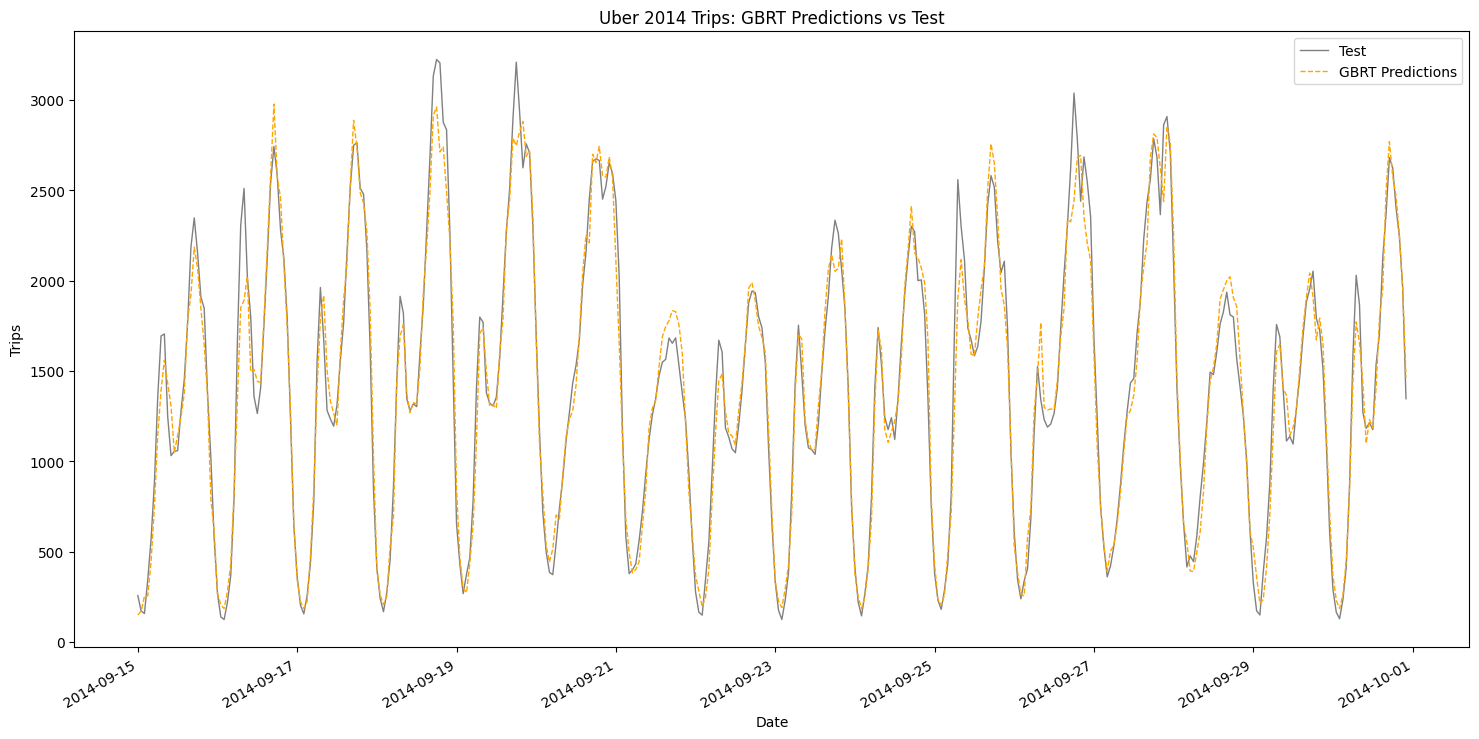

In [46]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange')],
    'Uber 2014 Trips: GBRT Predictions vs Test')

In [47]:
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
print(f'GBTR Percentage Error:\t{gbr_mape:.2%}')

GBTR Percentage Error:	10.02%


# Visualizing all models Together

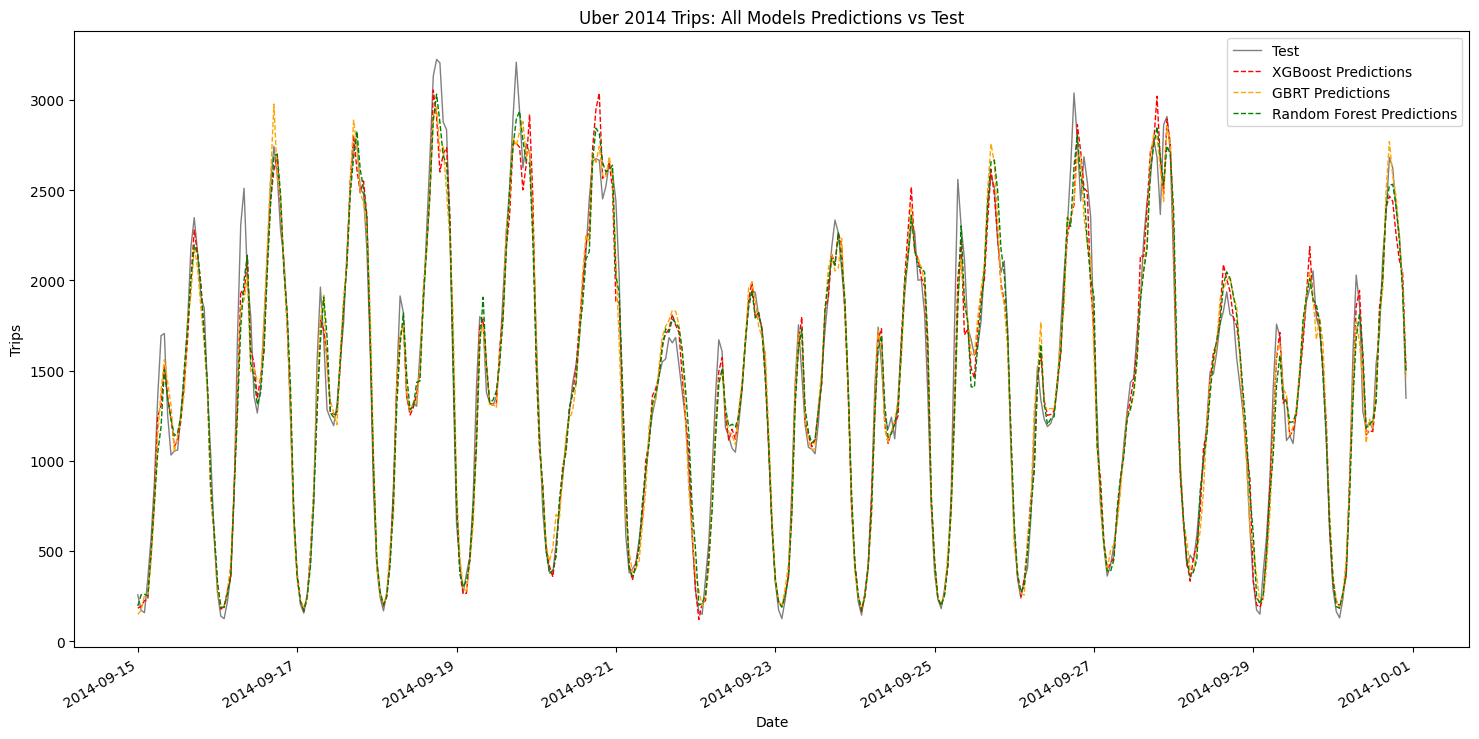

In [48]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,xgb_predictions,'XGBoost Predictions','--','red'),
    (uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange'),
    (uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],
    'Uber 2014 Trips: All Models Predictions vs Test')

The plot above illustrates that all algorithms have performed similarly in predicting the test set. Based on this visual assessment, it can be reasonably concluded that any of the algorithms would be a reliable choice. The final step is to implement an ensemble approach to potentially enhance performance.

# Ensemble

To build the ensemble, it is essential to first evaluate the performance of each algorithm individually. This analysis helps identify their respective strengths, enabling us to strategically combine them to maximize overall performance.

In [49]:
print(f'XGBoost MAPE:\t\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t\t{rf_mape:.2%}')
print(f'GBTR Percentage Error:\t\t{gbr_mape:.2%}')

XGBoost MAPE:			8.37%
Random Forest MAPE:		9.61%
GBTR Percentage Error:		10.02%


**Deriving Weights from MAPE Scores:** MAPE scores are inversely proportional to model performance, so their reciprocals can serve as an initial basis for assigning weights. To ensure the weights sum to 1, we normalize these reciprocals. The ensemble prediction formula can then be defined as follows:
- **Reciprocal of XGBoost MAPE:** 1/8.37≈0.119
- **Reciprocal of Random Forest MAPE:** 1/9.61≈0.104
- **Reciprocal of GBTR MAPE:** 1/10.02≈0.1
  
After summing these values and normalizing to calculate each model's respective weight, the ensemble prediction formula becomes:

**Ensemble Prediction = 0.368 × XGBoost Prediction + 0.322 × Random Forest Prediction + 0.310 × GBTR Prediction**

In [50]:
# Weights
weights = np.array([0.368, 0.322, 0.310])
# Combine predictions using weighted average
ensemble_predictions = (weights[0] * xgb_predictions + weights[1] * rf_predictions + weights[2] * gbr_predictions)

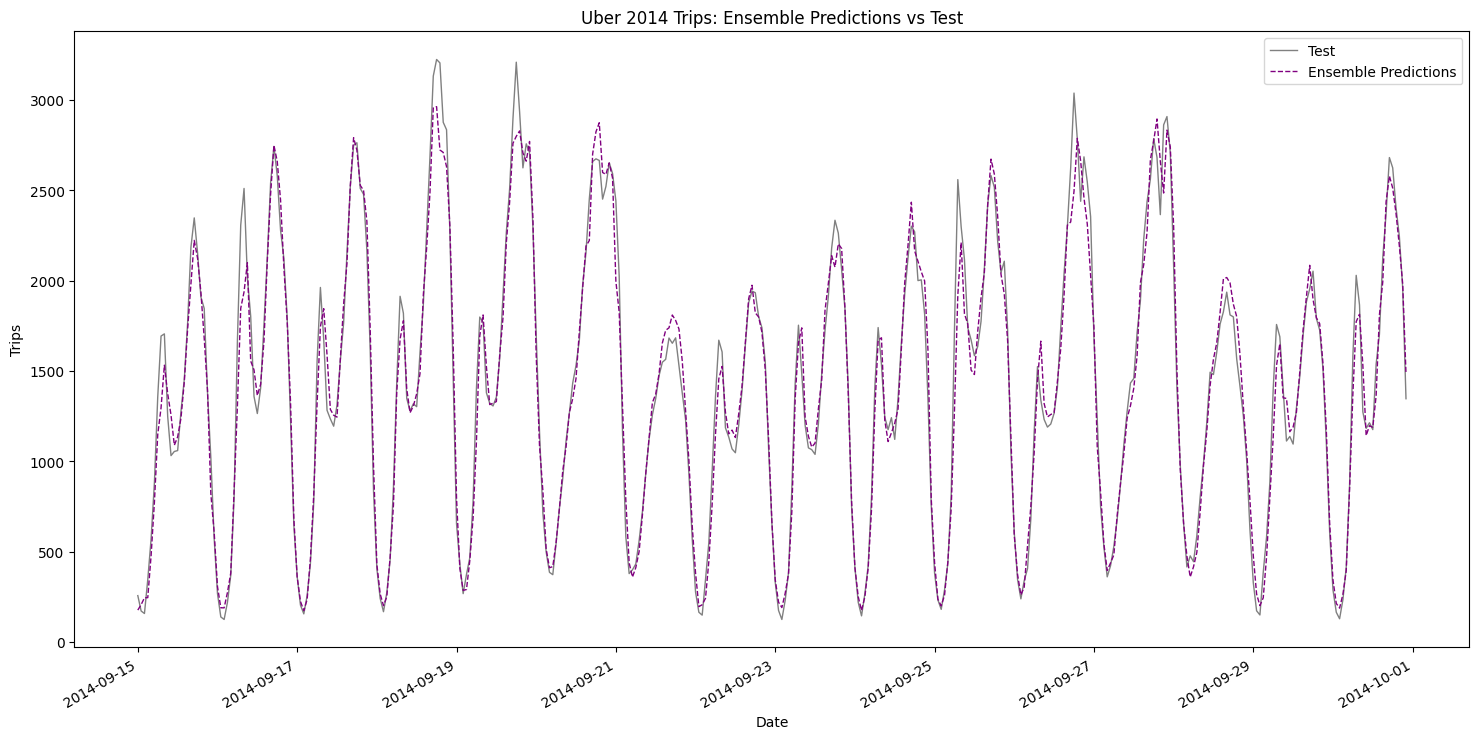

In [52]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,ensemble_predictions,'Ensemble Predictions','--','purple')],
    'Uber 2014 Trips: Ensemble Predictions vs Test')

In [53]:
# Calculate MAPE for ensemble predictions on test set
ensemble_mape = mean_absolute_percentage_error(uber2014_test['Count'],
ensemble_predictions)
print(f'Ensemble MAPE:\t{ensemble_mape:.2%}')

Ensemble MAPE:	8.60%


In [54]:
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t{rf_mape:.2%}')
print(f'GBTR MAPE:\t\t{gbr_mape:.2%}')
print(f'Ensemble MAPE:\t\t{ensemble_mape:.2%}')

XGBoost MAPE:		8.37%
Random Forest MAPE:	9.61%
GBTR MAPE:		10.02%
Ensemble MAPE:		8.60%


# Evaluation and it's Conclusion/Findings

**Model Performance Overview:**

- **XGBoost:** Achieving a MAPE of 8.37%, XGBoost emerged as the best-performing model. Its effectiveness in analyzing the 2014 Uber Trip data highlights its capability to handle intricate interactions and temporal patterns with precision.  
- **Random Forest:** With a MAPE of 9.61%, Random Forest demonstrated solid performance, leveraging its window-based approach to account for time-dependent variations effectively.  
- **Gradient Boosted Tree Regressor (GBTR):** Recording a MAPE of 10.02%, GBTR showed reasonable predictive power, though it fell short compared to XGBoost and Random Forest.  

**Ensemble Model Performance:**

- The ensemble model produced a MAPE of 8.60%, outperforming both Random Forest and GBTR. This result underscores the ensemble’s ability to combine the strengths of the individual models, delivering stable and enhanced predictions.  
- By integrating predictions from XGBoost, Random Forest, and GBTR, the ensemble capitalizes on the unique advantages of each, resulting in greater robustness.  

**Impact of Window-Based Training Logic:**

- The application of window-based logic to training proved highly effective in capturing temporal dependencies, improving predictive accuracy across all models.  
- This method ensured the models accounted for seasonality and trends, which are critical for time series forecasting in dynamic environments like ride-sharing demand.  

**Cross-Validation and Parameter Optimization:**

- Cross-validation provided a dependable framework for evaluating performance in temporal datasets, ensuring the models were robust and resistant to overfitting.  
- Fine-tuning parameters, particularly for XGBoost and GBTR, played a significant role in enhancing their accuracy, showcasing the value of effective optimization strategies.  

**Practical Implications:**

- For scenarios where minimizing error is crucial, XGBoost is the recommended choice due to its superior accuracy (MAPE of 8.37%).  
- The ensemble model offers a compelling alternative, delivering reliable predictions with improved overall accuracy compared to individual models, making it ideal for applications demanding stability.  

**Final Conclusion:**

This analysis highlights XGBoost as the leading performer, achieving a best-in-class MAPE of 8.37%. Meanwhile, the ensemble model, with a MAPE of 8.60%, effectively integrates the strengths of the individual models to produce robust and consistent predictions. These results underscore the importance of incorporating temporal structures into predictive modeling and provide a strong foundation for future applications in time series forecasting.  